In [21]:
# installing necessary libraries for the project
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install torch
!pip install transformers
!pip install joblib
!pip install matplotlib
!pip install seaborn
!pip install tqdm

In [5]:
# importing necessary libraries for the project.
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.svm import SVC
from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertModel
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
# I am using Apple silicon. The code below may have to be added according to your environment.
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [11]:
# Loading the datasets
# Making the CSV files in the same directory as your script
train_df = pd.read_csv('ru22fact_train.csv')
validate_df = pd.read_csv('ru22fact_validate.csv')
test_df = pd.read_csv('ru22fact_test.csv')
train_df = pd.read_csv('ru22fact_train.csv')
validate_df = pd.read_csv('ru22fact_validate.csv')
test_df = pd.read_csv('ru22fact_test.csv')

In [12]:
# Combining datasets and printing label information
combined_df = pd.concat([train_df, validate_df], ignore_index=True)

# Printing 'label'
print("Combined dataset:")
print(combined_df['label'].dtype)
print(combined_df['label'].value_counts(dropna=False))
print("\nTest dataset:")
print(test_df['label'].dtype)
print(test_df['label'].value_counts(dropna=False))

Combined dataset:
object
label
Supported    7915
Refuted      3749
NEI          1153
Name: count, dtype: int64

Test dataset:
object
label
Supported    2166
Refuted       902
NEI           148
Name: count, dtype: int64


After printing and reading the data, it is clear that there is some imbalance in the data set, but that can't be held as it is a real world dataset and to train the model accurately on real world scenarios. We would need this real world data set.

In [15]:
# defining a function to clean the label column
def clean_label(label):
    if pd.isna(label):
        return np.nan
    elif label == 'Supported':
        return 1
    elif label == 'Refuted':
        return 0
    else:
        return np.nan

# cleaning the label columns
combined_df['clean_label'] = combined_df['label'].apply(clean_label)
test_df['clean_label'] = test_df['label'].apply(clean_label)

# removing rows with NaN in clean_label
combined_df = combined_df.dropna(subset=['clean_label'])
test_df = test_df.dropna(subset=['clean_label'])

# Preparing the data by combining 'claim' and 'evidence'
X = combined_df['claim'] + ' ' + combined_df['evidence']
y = combined_df['clean_label']

# Doing the same for the test data
X_test = test_df['claim'] + ' ' + test_df['evidence']
y_test = test_df['clean_label']

# Loading the pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# function to get BERT embeddings
def get_bert_embeddings(texts, max_length=512):
    # First, I'm tokenizing and encoding the texts
    encoded = tokenizer(texts.tolist(), padding=True, truncation=True, max_length=max_length, return_tensors='pt')
    
    # Creating a DataLoader for batching
    dataset = TensorDataset(encoded['input_ids'], encoded['attention_mask'])
    dataloader = DataLoader(dataset, batch_size=32)
    
    # Getting BERT embeddings
    embeddings = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Getting BERT embeddings"):
            input_ids, attention_mask = batch
            outputs = bert_model(input_ids, attention_mask=attention_mask)
            embeddings.append(outputs.last_hidden_state[:, 0, :].numpy())  # Using [CLS] token embedding
    
    return np.vstack(embeddings)

/opt/anaconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Plea

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl


Fold 1/5
Generating embeddings for training data:


Generating BERT embeddings: 100%|█████████████| 292/292 [27:25<00:00,  5.63s/it]


Generating embeddings for validation data:


Generating BERT embeddings: 100%|███████████████| 73/73 [05:40<00:00,  4.66s/it]


Training SVC model...
Evaluating model...
Validation Accuracy: 0.8907
Validation F1 Score: 0.8905
Validation Recall: 0.8907
Validation Precision: 0.8903

Fold 2/5
Generating embeddings for training data:


Generating BERT embeddings: 100%|█████████████| 292/292 [24:09<00:00,  4.96s/it]


Generating embeddings for validation data:


Generating BERT embeddings: 100%|███████████████| 73/73 [05:48<00:00,  4.77s/it]


Training SVC model...
Evaluating model...
Validation Accuracy: 0.8800
Validation F1 Score: 0.8792
Validation Recall: 0.8800
Validation Precision: 0.8790

Fold 3/5
Generating embeddings for training data:


Generating BERT embeddings: 100%|█████████████| 292/292 [24:08<00:00,  4.96s/it]


Generating embeddings for validation data:


Generating BERT embeddings: 100%|███████████████| 73/73 [05:50<00:00,  4.80s/it]


Training SVC model...
Evaluating model...
Validation Accuracy: 0.8834
Validation F1 Score: 0.8823
Validation Recall: 0.8834
Validation Precision: 0.8822

Fold 4/5
Generating embeddings for training data:


Generating BERT embeddings: 100%|█████████████| 292/292 [23:03<00:00,  4.74s/it]


Generating embeddings for validation data:


Generating BERT embeddings: 100%|███████████████| 73/73 [05:46<00:00,  4.75s/it]


Training SVC model...
Evaluating model...
Validation Accuracy: 0.8817
Validation F1 Score: 0.8808
Validation Recall: 0.8817
Validation Precision: 0.8805

Fold 5/5
Generating embeddings for training data:


Generating BERT embeddings: 100%|█████████████| 292/292 [23:17<00:00,  4.79s/it]


Generating embeddings for validation data:


Generating BERT embeddings: 100%|███████████████| 73/73 [05:50<00:00,  4.80s/it]


Training SVC model...
Evaluating model...
Validation Accuracy: 0.8726
Validation F1 Score: 0.8722
Validation Recall: 0.8726
Validation Precision: 0.8719

Average results across all folds:
Validation Accuracy: 0.8817 (+/- 0.0058)
Validation F1 Score: 0.8810 (+/- 0.0059)
Validation Recall: 0.8817 (+/- 0.0058)
Validation Precision: 0.8808 (+/- 0.0059)

Training final model on entire dataset:


Generating BERT embeddings: 100%|█████████████| 365/365 [29:32<00:00,  4.86s/it]



Evaluating on test set:


Generating BERT embeddings: 100%|███████████████| 96/96 [07:42<00:00,  4.82s/it]



Final Test Results:
Test Accuracy: 0.9061
Test F1 Score: 0.9068
Test Recall: 0.9061
Test Precision: 0.9078


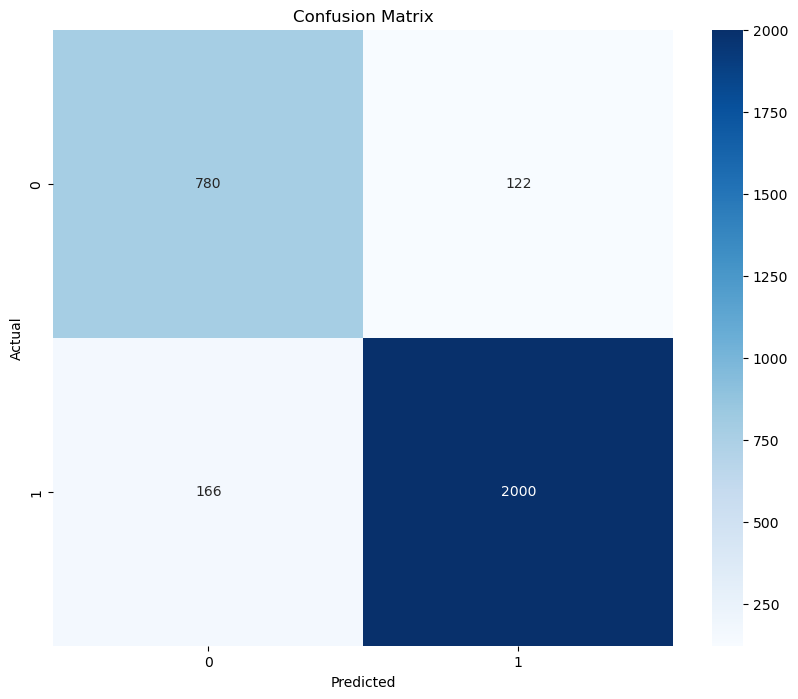


Saving models and tokenizer...
Models and tokenizer saved successfully.


In [16]:
# Loading the BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

# Defining a function to get BERT embeddings
def get_bert_embeddings(texts, batch_size=32):
    all_embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Generating BERT embeddings"):
        batch = texts[i:i+batch_size].tolist()
        encoded_input = tokenizer(batch, padding=True, truncation=True, return_tensors='pt', max_length=512)
        with torch.no_grad():
            encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
            model_output = bert_model(**encoded_input)
        embeddings = model_output.last_hidden_state[:, 0, :].cpu().numpy()
        all_embeddings.append(embeddings)
    return np.vstack(all_embeddings)

# Setting up the k-fold cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Storing the list for each fold
val_accuracies, val_f1_scores, val_recalls, val_precisions = [], [], [], []

# Performing k-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(X), 1):
    print(f"\nFold {fold}/{n_splits}")
    
    # Splitting the data for this fold
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Getting BERT embeddings for this fold
    print("Generating embeddings for training data:")
    X_train_embeddings = get_bert_embeddings(X_train)
    print("Generating embeddings for validation data:")
    X_val_embeddings = get_bert_embeddings(X_val)
    
    # Training the SVC model for this fold
    print("Training SVC model...")
    model = SVC(kernel='linear', random_state=42)
    model.fit(X_train_embeddings, y_train)
    
    # Evaluating the model on the validation set
    print("Evaluating model...")
    val_preds = model.predict(X_val_embeddings)
    val_accuracy = accuracy_score(y_val, val_preds)
    val_f1 = f1_score(y_val, val_preds, average='weighted')
    val_recall = recall_score(y_val, val_preds, average='weighted')
    val_precision = precision_score(y_val, val_preds, average='weighted')
    
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation F1 Score: {val_f1:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")
    print(f"Validation Precision: {val_precision:.4f}")
    
    # Storing the results of this fold
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)
    val_recalls.append(val_recall)
    val_precisions.append(val_precision)

# Calculating and printing average results across all folds
print("\nAverage results across all folds:")
print(f"Validation Accuracy: {np.mean(val_accuracies):.4f} (+/- {np.std(val_accuracies):.4f})")
print(f"Validation F1 Score: {np.mean(val_f1_scores):.4f} (+/- {np.std(val_f1_scores):.4f})")
print(f"Validation Recall: {np.mean(val_recalls):.4f} (+/- {np.std(val_recalls):.4f})")
print(f"Validation Precision: {np.mean(val_precisions):.4f} (+/- {np.std(val_precisions):.4f})")

# Training the final model on the entire dataset
print("\nTraining final model on entire dataset:")
X_combined_embeddings = get_bert_embeddings(X)
model = SVC(kernel='linear', random_state=42)
model.fit(X_combined_embeddings, y)

# Evaluating on the test set
print("\nEvaluating on test set:")
X_test_embeddings = get_bert_embeddings(X_test)
test_preds = model.predict(X_test_embeddings)
test_accuracy = accuracy_score(y_test, test_preds)
test_f1 = f1_score(y_test, test_preds, average='weighted')
test_recall = recall_score(y_test, test_preds, average='weighted')
test_precision = precision_score(y_test, test_preds, average='weighted')

print("\nFinal Test Results:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test Precision: {test_precision:.4f}")

# Creating a confusion matrix
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Saving my models and tokenizer
print("\nSaving models and tokenizer...")
torch.save(bert_model.state_dict(), 'bert_model.pth')
joblib.dump(model, 'svc_model.joblib')
tokenizer.save_pretrained('bert_tokenizer')

print("Models and tokenizer saved successfully.")

The development of a BERT-based model aimed at analyzing the text and most importantly using k-fold cross-validation as a way to assess its effectiveness. The final model is trained on the entire data set while a separate test set is used for evaluation yielding various metrics such as accuracy, F1 score, recall and precision. A confusion matrix has also been created in order to visualize the performance of the model and save BERT model, SVC classifier and tokenizer for future use. In another step, I’m going to try this model out on RSS data
